# 01 — Data Overview & Validation (EA7 Macro Panel)

This notebook validates and documents the final cleaned macro panel dataset used in the project.

**Dataset:** `data/processed/macro_panel.csv`  
**Panel:** 7 euro area countries (EA7), monthly frequency  
**Period:** 2010-01 to 2023-12 (balanced)

### Goals
1. Confirm the panel is balanced (same months for each country).
2. Check missing values and basic data quality.
3. Produce first descriptive summaries and visual sanity checks.
4. Save a small validation report (optional).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

DATA_PATH = Path("../data/processed/macro_panel.csv")
assert DATA_PATH.exists(), f"Missing file: {DATA_PATH.resolve()}"

In [2]:
df = pd.read_csv(DATA_PATH)

print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head()

Rows: 1176
Columns: ['country', 'month', 'rti_index', 'hicp_index', 'hfce', 'cci', 'us_cpi', 'us_unemployment', 'us_fed_funds', 'us_industrial_prod']


,country,month,rti_index,hicp_index,hfce,cci,us_cpi,us_unemployment,us_fed_funds,us_industrial_prod
0,AT,2010-01,99.5,108.12,NaN,-4.9,217.488,9.8,0.11,89.3426
1,AT,2010-02,100.7,108.34,NaN,-4.6,217.281,9.8,0.13,89.6779
2,AT,2010-03,100.7,109.46,NaN,-8.6,217.353,9.9,0.16,90.2928
3,AT,2010-04,99.9,109.69,NaN,-5.8,217.403,9.9,0.20,90.5991
4,AT,2010-05,99.4,109.63,NaN,-9.9,217.290,9.6,0.20,91.8230


In [3]:
print("Countries:", df["country"].nunique(), sorted(df["country"].unique()))
print("Min month:", df["month"].min())
print("Max month:", df["month"].max())

counts = df.groupby("country")["month"].count().sort_values()
print("\nObservations per country:")
print(counts)

balanced = counts.nunique() == 1
print("\nBalanced panel:", balanced)
print("Months per country:", counts.iloc[0] if balanced else "NOT BALANCED")
print("Expected total rows if balanced:", df["country"].nunique() * (counts.iloc[0] if balanced else 0))

Countries: 7 ['AT', 'DE', 'ES', 'FI', 'FR', 'IT', 'NL']
Min month: 2010-01
Max month: 2023-12

Observations per country:
country
AT    168
DE    168
ES    168
FI    168
FR    168
IT    168
NL    168
Name: month, dtype: int64

Balanced panel: True
Months per country: 168
Expected total rows if balanced: 1176


## Panel structure

A balanced monthly panel is important because it allows:
- cross-country comparisons without missing-time bias,
- consistent aggregation,
- clean panel regressions and event studies later.

We verify:
- the number of countries equals 7,
- each country has the same number of monthly observations,
- the time window is consistent across countries.

In [4]:
# Create a proper month timestamp for plotting and time filtering
df["month_dt"] = pd.to_datetime(df["month"].str.cat(["-01"] * len(df)))

# Sort
df = df.sort_values(["country", "month_dt"]).reset_index(drop=True)

df[["country", "month", "month_dt"]].head()

,country,month,month_dt
0,AT,2010-01,2010-01-01
1,AT,2010-02,2010-02-01
2,AT,2010-03,2010-03-01
3,AT,2010-04,2010-04-01
4,AT,2010-05,2010-05-01


In [5]:
missing = df.isna().mean().sort_values(ascending=False)
missing_counts = df.isna().sum().sort_values(ascending=False)

summary_missing = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_share": missing
})

summary_missing

,missing_count,missing_share
hfce,1176,1.00000
cci,1,0.00085
country,0,0.00000
month,0,0.00000
rti_index,0,0.00000
hicp_index,0,0.00000
us_cpi,0,0.00000
us_unemployment,0,0.00000
us_fed_funds,0,0.00000
us_industrial_prod,0,0.00000


### Note on HFCE

Household Final Consumption Expenditure (HFCE) was initially included as an annual macro indicator.
However, due to limited coverage in recent years and weak alignment with monthly dynamics,
HFCE was excluded from the final analytical dataset.

The final panel therefore focuses on fully observed, monthly indicators that directly capture
retail activity, inflation, expectations, and global financial conditions.

In [6]:
df = df.drop(columns=["hfce"])

num_cols = [c for c in df.columns if c not in ["country", "month", "month_dt"]]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
rti_index,1176.0,103.861990,7.731165,69.7000,99.00000,102.4000,108.30000,127.1000
hicp_index,1176.0,122.978588,10.123865,105.5200,116.42500,121.1900,125.94250,161.7000
cci,1175.0,-10.410128,8.958439,-40.5000,-16.40000,-9.2000,-3.55000,7.0000
us_cpi,1176.0,249.877536,24.323323,217.1990,232.92775,243.1275,259.15775,308.7350
us_unemployment,1176.0,5.924405,2.257287,3.4000,3.90000,5.1000,7.72500,14.8000
us_fed_funds,1176.0,0.949702,1.401871,0.0500,0.09000,0.1650,1.44250,5.3300
us_industrial_prod,1176.0,99.089273,3.557745,84.5619,97.70605,100.0944,101.33400,104.1004


In [7]:
dup = df.duplicated(subset=["country", "month"]).sum()
print("Duplicate country-month rows:", dup)

assert dup == 0, "Found duplicate country-month rows. Investigate before proceeding."

Duplicate country-month rows: 0


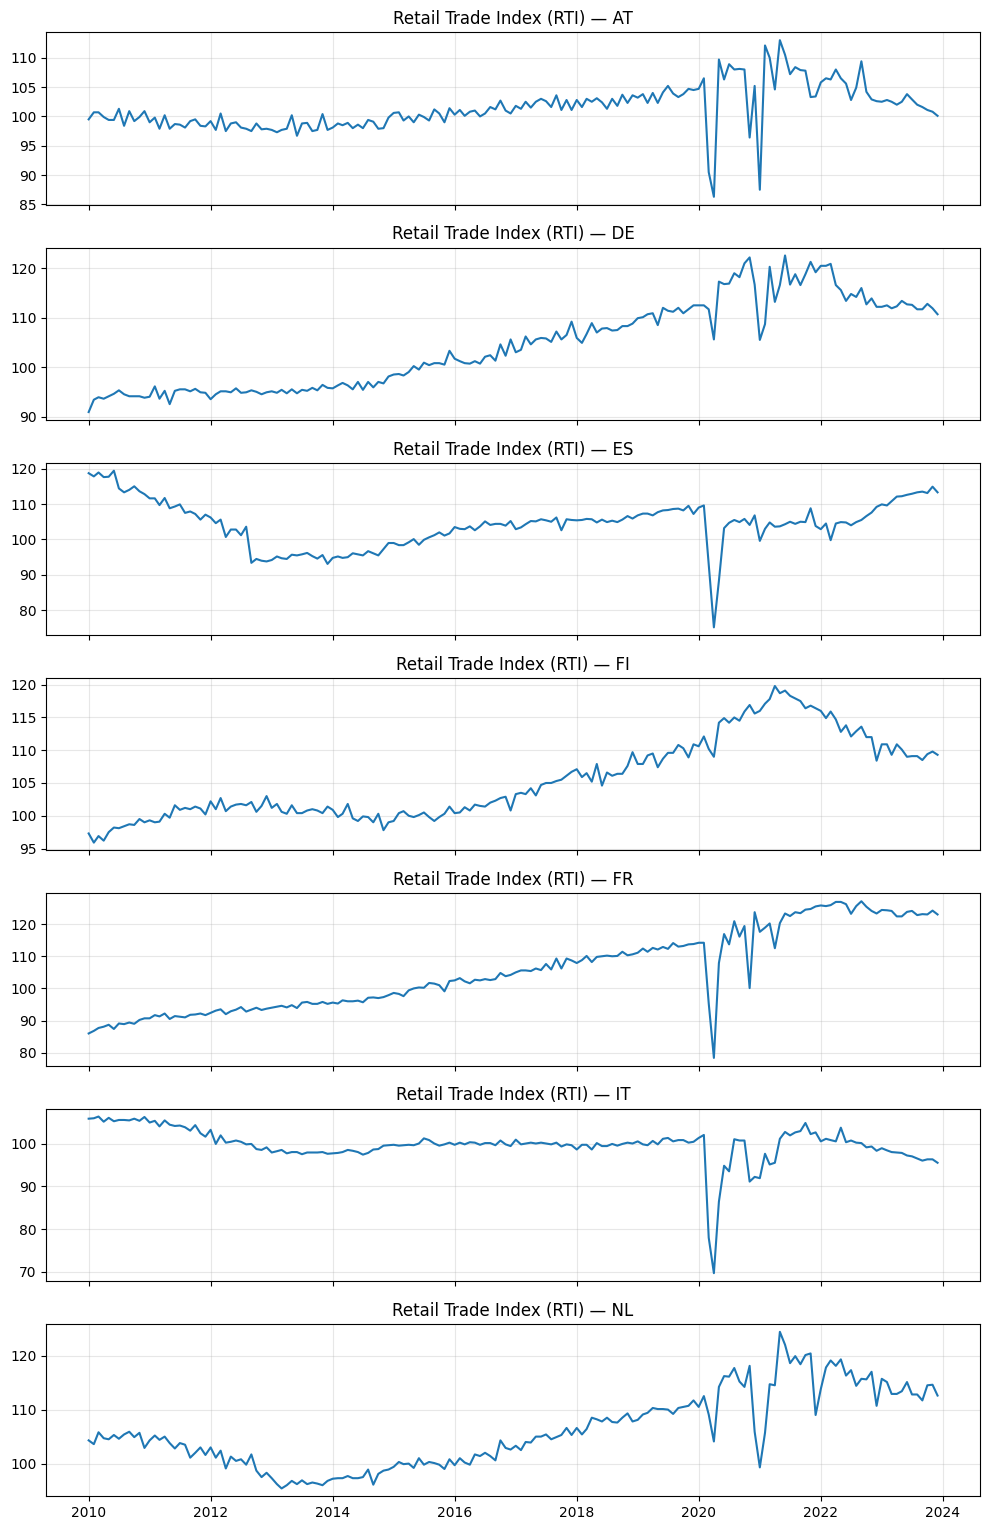

In [8]:
countries = sorted(df["country"].unique())

fig, axes = plt.subplots(len(countries), 1, figsize=(10, 2.2 * len(countries)), sharex=True)

for ax, c in zip(axes, countries):
    sub = df[df["country"] == c]
    ax.plot(sub["month_dt"], sub["rti_index"])
    ax.set_title(f"Retail Trade Index (RTI) — {c}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Retail Trade Index (RTI) — visual sanity check

We expect to see:
- a sharp disruption around 2020 (COVID shock),
- recovery thereafter,
- country differences in amplitude and volatility.

This plot is not “analysis” yet — it is a sanity check that the series behaves plausibly.

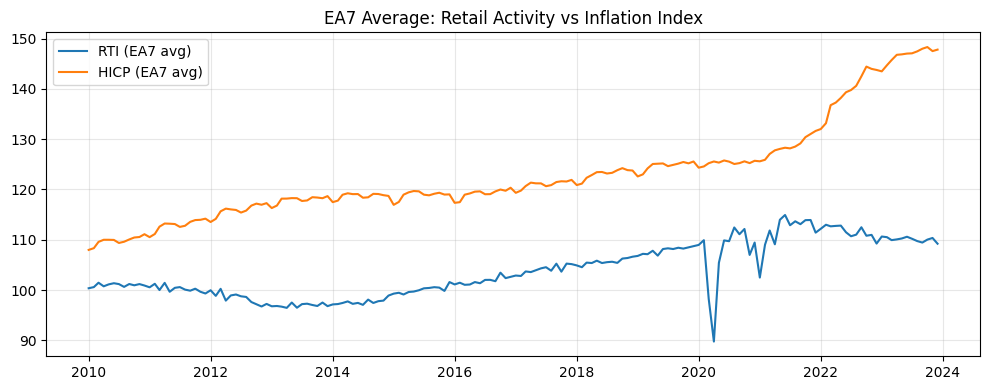

In [9]:
ea7 = df.groupby("month_dt", as_index=False)[["rti_index", "hicp_index"]].mean()

fig = plt.figure(figsize=(10, 4))
plt.plot(ea7["month_dt"], ea7["rti_index"], label="RTI (EA7 avg)")
plt.plot(ea7["month_dt"], ea7["hicp_index"], label="HICP (EA7 avg)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("EA7 Average: Retail Activity vs Inflation Index")
plt.tight_layout()
plt.show()

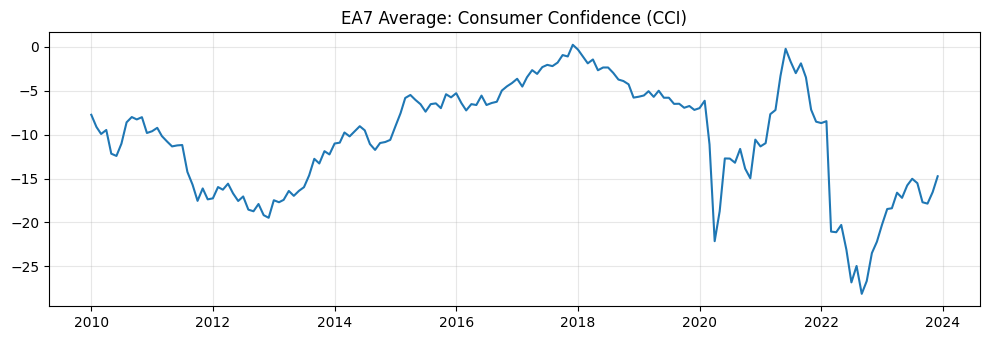

In [10]:
ea7_cci = df.groupby("month_dt", as_index=False)[["cci"]].mean()

plt.figure(figsize=(10, 3.5))
plt.plot(ea7_cci["month_dt"], ea7_cci["cci"])
plt.grid(True, alpha=0.3)
plt.title("EA7 Average: Consumer Confidence (CCI)")
plt.tight_layout()
plt.show()

In [11]:
ea7_avg = df.groupby("month_dt", as_index=False)[num_cols].mean()
corr = ea7_avg[num_cols].corr()
corr

,rti_index,hicp_index,cci,us_cpi,us_unemployment,us_fed_funds,us_industrial_prod
rti_index,1.000000,0.732244,0.046406,0.803585,-0.549271,0.504174,0.263446
hicp_index,0.732244,1.000000,-0.339340,0.988825,-0.617886,0.782446,0.417456
cci,0.046406,-0.339340,1.000000,-0.281923,-0.268915,-0.185275,0.224993
us_cpi,0.803585,0.988825,-0.281923,1.000000,-0.623667,0.735519,0.397983
us_unemployment,-0.549271,-0.617886,-0.268915,-0.623667,1.000000,-0.570864,-0.852803
us_fed_funds,0.504174,0.782446,-0.185275,0.735519,-0.570864,1.000000,0.373153
us_industrial_prod,0.263446,0.417456,0.224993,0.397983,-0.852803,0.373153,1.000000


## Summary (Notebook 01)

We confirmed:
- the dataset is a balanced monthly panel across EA7,
- the time window is consistent across countries,
- basic descriptive statistics look plausible,
- time series plots show credible dynamics (e.g., major shocks).

Next, we move from validation to **economic analysis**, starting with:
**Notebook 02 — Retail Activity Dynamics (RTI)**.